# Read Jaw Clench EMG Artifact
Extract all files and do machine learning training on it. For baseline training

Data for trial 1.txt of shape (1, 1, 31493, 8)
Data for trial 2.txt of shape (1, 1, 31405, 8)
Data for trial 3.txt of shape (1, 1, 31428, 8)
eeg_seg has shape = (3, 24, 750, 8)
Y_front_temp has shape = (3, 24, 1)
Data for trial 1.txt of shape (1, 1, 31370, 8)
Data for trial 2.txt of shape (1, 1, 31316, 8)
Data for trial 3.txt of shape (1, 1, 31305, 8)
eeg_seg has shape = (3, 24, 750, 8)
Y_front_temp has shape = (3, 24, 1)
Data for trial 1.txt of shape (1, 1, 31263, 8)
Data for trial 2.txt of shape (1, 1, 31308, 8)
Data for trial 3.txt of shape (1, 1, 31319, 8)
eeg_seg has shape = (3, 24, 750, 8)
Y_front_temp has shape = (3, 24, 1)
Data for trial 1.txt of shape (1, 1, 31288, 8)
Data for trial 2.txt of shape (1, 1, 31366, 8)
Data for trial 3.txt of shape (1, 1, 31758, 8)
eeg_seg has shape = (3, 24, 750, 8)
Y_front_temp has shape = (3, 24, 1)
Data for trial 1.txt of shape (1, 1, 31287, 8)
Data for trial 2.txt of shape (1, 1, 31351, 8)
Data for trial 3.txt of shape (1, 1, 31462, 8)
eeg_seg

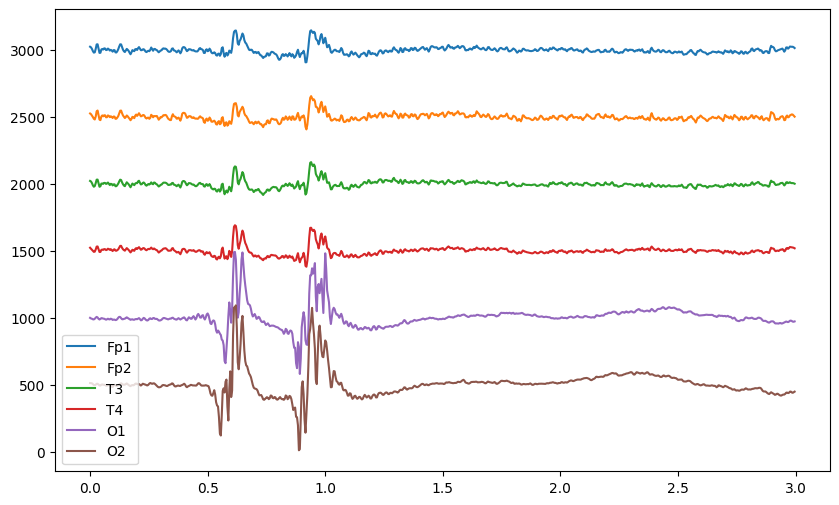

In [43]:
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
# Parameters
low_freq, high_freq, filter_order = 2, 50, 2
bool_band_pass, bool_notch = True, True
num_clench_per_record = 24
segment_len_s = 3
clench_interval_s = 5
offset_s = -0.5
trials = ['1','2','3']
# subjects = ['gtl','gtl2']
subjects = ['Nothing','Left_Eye','Right_Eye','Jaw_Clench','Dbl_Clench']
sample_rate = 250

# Get data and perform BPF
for m, subject in enumerate(subjects):
    array = dict()
    filtered_array = dict()
    for i, trial in enumerate(trials):
        array[i] = get_openbci_text.import_text_file(os.path.join('data',subject,trial+'.txt'))
        array[i] = get_openbci_text.filter_eeg_columns(array[i])
        filtered_array[i] = digital_filter.perform_filter(array[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        # filtered_array[i] = filtered_array[i][:,:,int(sample_rate*length_samples_offset_s):int(length_samples_s*sample_rate)+int(sample_rate*length_samples_offset_s),:]
        print('Data for trial {}.txt of shape {}'.format(trial, filtered_array[i].shape))
    
    # Segment data to segment_len_s intervals
    eeg_seg = np.zeros((len(trials),num_clench_per_record,int(sample_rate*segment_len_s),filtered_array[0].shape[3]))
    array_seg = dict()
    for i, trial in enumerate(trials):
        for j in range(num_clench_per_record):
            eeg_seg[i,j] = filtered_array[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
    print('eeg_seg has shape = {}'.format(eeg_seg.shape))
    if m==0:
        X_front = np.copy(eeg_seg)
    else:
        X_front = np.concatenate((X_front,np.copy(eeg_seg)),axis=0)
    
    # Create y label
    Y_front_temp = np.zeros((len(trials),num_clench_per_record,1))
    for i, trial in enumerate(trials):
        Y_front_temp[i,:,:] = m
        
    print('Y_front_temp has shape = {}'.format(Y_front_temp.shape))
    if m==0:
        Y_front = np.copy(Y_front_temp)
    else:
        Y_front = np.concatenate((Y_front,np.copy(Y_front_temp)),axis=0)

# Plot
plot_trial, plot_segment = 0, 12   # 0-8, 0-23
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,0]+500*6)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,1]+500*5)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,2]+500*4)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,3]+500*3)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,5]+500*2)
plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,6]+500)
plt.legend(['Fp1','Fp2','T3','T4','O1','O2'])
plt.show()

In [44]:
# Train-Val Split and Augment Dataset
# For eeg_front
X_train_front, Y_train_front, X_val_front, Y_val_front = pre_process.pre_process_dataset(X_front, Y_front, is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)

Performing pre-process for input dataset
Input shape data.X = (15, 24, 750, 8), data.Y = (15, 24, 1)
== Pre-Process == => No Software Spectrum Filtering Performed
== Pre-Process == => No normalization performed
== Pre-Process == => Performing train-val split on dataset
dataset_X.shape=(15, 24, 750, 8), dataset_Y.shape=(15, 24, 1)
X_train.shape=(15, 19, 750, 8), X_val.shape=(15, 5, 750, 8)
== Pre-Process == => Performing sample augmentation on dataset
== Pre-Process == => Downsample with factor = 1
Output shape X_train=(15, 475, 500, 8), Y_train=(15, 475, 1), X_val=(15, 125, 500, 8), Y_val=(15, 125, 1)


In [45]:
# # np.save(os.path.join('data','trial','X_train_front.npy'), X_train_front)
# # np.save(os.path.join('data','trial','Y_train_front.npy'), Y_train_front)
# # np.save(os.path.join('data','trial','X_val_front.npy'), X_val_front)
# # np.save(os.path.join('data','trial','Y_val_front.npy'), Y_val_front)

# # np.save(os.path.join('data','trial','X_train_back.npy'), X_train_back)
# # np.save(os.path.join('data','trial','Y_train_back.npy'), Y_train_back)
# # np.save(os.path.join('data','trial','X_val_back.npy'), X_val_back)
# # np.save(os.path.join('data','trial','Y_val_back.npy'), Y_val_back)

# X_train_front = np.load(os.path.join('data','trial','X_train_front.npy'))
# Y_train_front = np.load(os.path.join('data','trial','Y_train_front.npy'))
# X_val_front = np.load(os.path.join('data','trial','X_val_front.npy'))
# Y_val_front = np.load(os.path.join('data','trial','Y_val_front.npy'))

# X_train_back = np.load(os.path.join('data','trial','X_train_back.npy'))
# Y_train_back = np.load(os.path.join('data','trial','Y_train_back.npy'))
# X_val_back = np.load(os.path.join('data','trial','X_val_back.npy'))
# Y_val_back = np.load(os.path.join('data','trial','Y_val_back.npy'))

In [46]:
# Remove channels to see if have impact
X_train_front = X_train_front[:,:,:,[0,1,2,3,5,6]]
X_val_front   = X_val_front[:,:,:,[0,1,2,3,5,6]]
print(X_train_front.shape, X_val_front.shape)

(15, 475, 500, 6) (15, 125, 500, 6)


Shape before trimming = (7125, 1, 6, 500)
Shape after trimming = (7125, 1, 6, 500)
Shape before trimming = (1875, 1, 6, 500)
Shape after trimming = (1875, 1, 6, 500)
input1 shape = (None, 1, 6, 500). Chans = 6, Samples = 500
block1 first stage shape = (None, 12, 6, 500). F1 = 12, kernLength = 256, Chans = 6, Samples = 500
block1 second stage shape = (None, 24, 1, 500). Chans = 6, D = 2
block1 avg pool stage shape = (None, 24, 1, 125). AveragePooling2D Params (hardcoded)= (1, 4)
block1 dropout stage shape = (None, 24, 1, 125). dropoutRate = 0.25
block2 1st stage shape = (None, 24, 1, 125). F2 = 24, param_2 (hardcoded)= (1, 16)
block2 avg pool stage shape = (None, 24, 1, 15). AveragePooling2D params (hardcoded) = (1, 8)
block2 dropout stage shape = (None, 24, 1, 15). dropoutRate = 0.25
flatten shape = (None, 360)
dense shape = (None, 5). nb_classes = 5, norm_rate = 0.25
Start Training: EEGNet setup with parameters nb_classes=5, Chans=6, F1=12, D=2, F2=24, Trials=7125, Samples=500
Regular

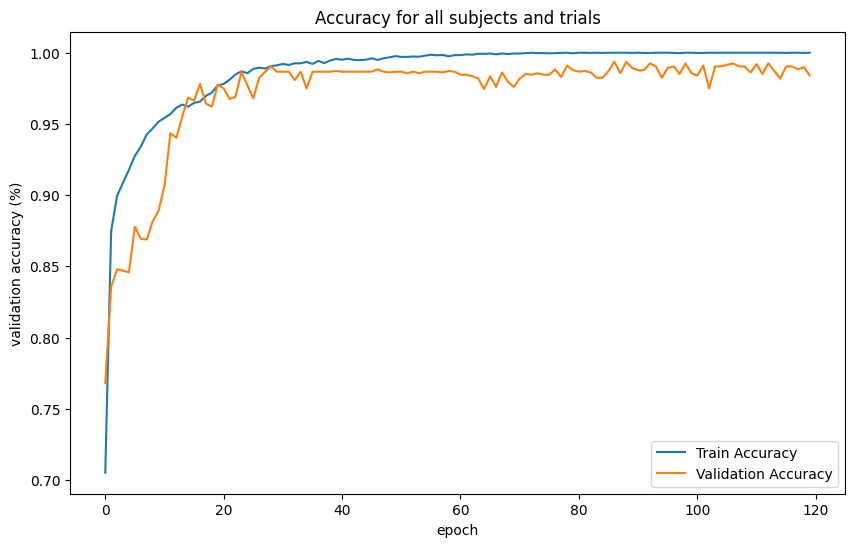

Final train accuracy = 1.0, Final val accuracy = 0.984000027179718


In [47]:
trained_model, history = run_eegnet.train_eegnet(X_train_front, Y_train_front, X_val_front, Y_val_front, index_subject_to_train=-1, 
                                        epoch = 120, learning_rate = 0.001, batch_size = 256, F1=12, D = 2, F2=24,
                                        regularize = [False, 'L2', 0.001], model = 'eegnet', kernLength=256)
print('Final train accuracy = {}, Final val accuracy = {}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

Shape before trimming = (1875, 1, 6, 500)
Shape after trimming = (1875, 1, 6, 500)


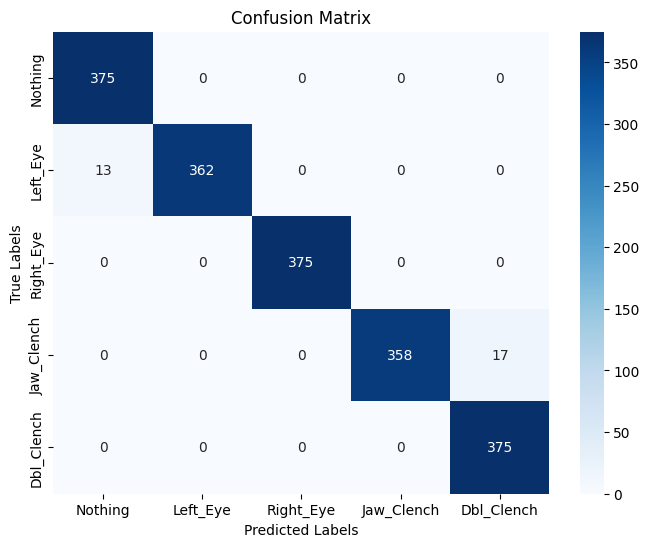

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_val_front, trained_model, index_subject_to_predict=-1, data_Y=Y_val_front)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subjects, yticklabels=subjects)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Load Test Set to test

In [37]:
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
# Parameters
low_freq, high_freq, filter_order = 2, 50, 2
bool_band_pass, bool_notch = True, True
num_clench_per_record = 24
segment_len_s = 3
clench_interval_s = 5
offset_s = -0.5
trials = ['3']
# subjects = ['gtl','gtl2']
subjects = ['Nothing','Left_Eye','Right_Eye','Jaw_Clench','Dbl_Clench']
sample_rate = 250

# Get data and perform BPF
for m, subject in enumerate(subjects):
    array = dict()
    filtered_array = dict()
    for i, trial in enumerate(trials):
        array[i] = get_openbci_text.import_text_file(os.path.join('data',subject,trial+'.txt'))
        array[i] = get_openbci_text.filter_eeg_columns(array[i])
        filtered_array[i] = digital_filter.perform_filter(array[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        # filtered_array[i] = filtered_array[i][:,:,int(sample_rate*length_samples_offset_s):int(length_samples_s*sample_rate)+int(sample_rate*length_samples_offset_s),:]
        print('Data for trial {}.txt of shape {}'.format(trial, filtered_array[i].shape))
    
    # Segment data to segment_len_s intervals
    eeg_seg = np.zeros((len(trials),num_clench_per_record,int(sample_rate*segment_len_s),filtered_array[0].shape[3]))
    array_seg = dict()
    for i, trial in enumerate(trials):
        for j in range(num_clench_per_record):
            eeg_seg[i,j] = filtered_array[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
    print('eeg_seg has shape = {}'.format(eeg_seg.shape))
    if m==0:
        X_front = np.copy(eeg_seg)
    else:
        X_front = np.concatenate((X_front,np.copy(eeg_seg)),axis=0)
    
    # Create y label
    Y_front_temp = np.zeros((len(trials),num_clench_per_record,1))
    for i, trial in enumerate(trials):
        Y_front_temp[i,:,:] = m
        
    print('Y_front_temp has shape = {}'.format(Y_front_temp.shape))
    if m==0:
        Y_front = np.copy(Y_front_temp)
    else:
        Y_front = np.concatenate((Y_front,np.copy(Y_front_temp)),axis=0)

Data for trial 3.txt of shape (1, 1, 31428, 8)
eeg_seg has shape = (1, 24, 750, 8)
Y_front_temp has shape = (1, 24, 1)
Data for trial 3.txt of shape (1, 1, 31305, 8)
eeg_seg has shape = (1, 24, 750, 8)
Y_front_temp has shape = (1, 24, 1)
Data for trial 3.txt of shape (1, 1, 31319, 8)
eeg_seg has shape = (1, 24, 750, 8)
Y_front_temp has shape = (1, 24, 1)
Data for trial 3.txt of shape (1, 1, 31758, 8)
eeg_seg has shape = (1, 24, 750, 8)
Y_front_temp has shape = (1, 24, 1)
Data for trial 3.txt of shape (1, 1, 31462, 8)
eeg_seg has shape = (1, 24, 750, 8)
Y_front_temp has shape = (1, 24, 1)


In [38]:
# Train-Val Split and Augment Dataset
# For eeg_front
X_train_front, Y_train_front, X_val_front, Y_val_front = pre_process.pre_process_dataset(X_front, Y_front, is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)

Performing pre-process for input dataset
Input shape data.X = (5, 24, 750, 8), data.Y = (5, 24, 1)
== Pre-Process == => No Software Spectrum Filtering Performed
== Pre-Process == => No normalization performed
== Pre-Process == => Performing train-val split on dataset
dataset_X.shape=(5, 24, 750, 8), dataset_Y.shape=(5, 24, 1)
X_train.shape=(5, 19, 750, 8), X_val.shape=(5, 5, 750, 8)
== Pre-Process == => Performing sample augmentation on dataset
== Pre-Process == => Downsample with factor = 1
Output shape X_train=(5, 475, 500, 8), Y_train=(5, 475, 1), X_val=(5, 125, 500, 8), Y_val=(5, 125, 1)


In [39]:
# Remove channels to see if have impact
X_train_front = X_train_front[:,:,:,[0,1,2,3,5,6]]
X_val_front   = X_val_front[:,:,:,[0,1,2,3,5,6]]
print(X_train_front.shape, X_val_front.shape)

(5, 475, 500, 6) (5, 125, 500, 6)


Shape before trimming = (625, 1, 6, 500)
Shape after trimming = (625, 1, 6, 500)
Shape before trimming = (2375, 1, 6, 500)
Shape after trimming = (2375, 1, 6, 500)
0.9006316065788269


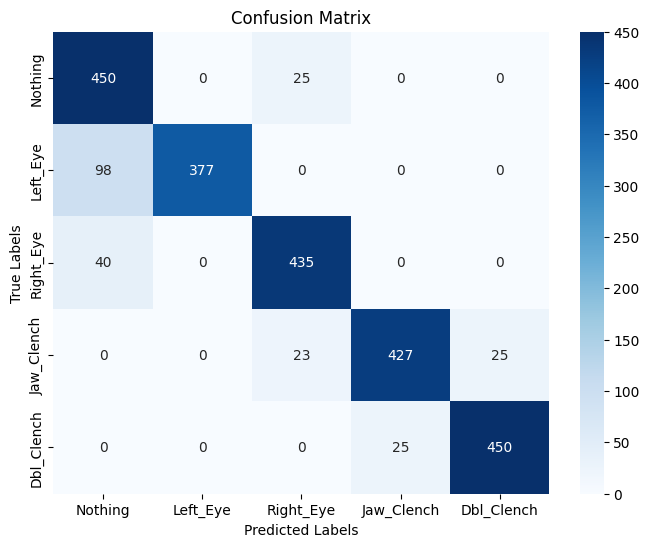

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_val_front, trained_model, index_subject_to_predict=-1, data_Y=Y_val_front)
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_train_front, trained_model, index_subject_to_predict=-1, data_Y=Y_train_front)
print(accuracy)
# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subjects, yticklabels=subjects)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_val_front, trained_model, index_subject_to_predict=-1, data_Y=Y_val_front)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subjects, yticklabels=subjects)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
X_val_front.shape

(15, 125, 500, 6)

In [50]:
# Save and load model
run_eegnet.save_model('trained_model', trained_model, model_name_full='spotify_model')
loaded_model_jaw =run_eegnet.load_full_model('trained_model','spotify_model')

INFO:tensorflow:Assets written to: trained_model\spotify_model\assets
Created and saved full model spotify_model to trained_model
Loading Model from  trained_model\spotify_model


In [ ]:
trained_model_back, history_back = run_eegnet.train_eegnet(X_train_back, Y_train_back, X_val_back, Y_val_back, index_subject_to_train=-1, 
                                        epoch = 100, learning_rate = 0.001, batch_size = 256, F1=12, D = 2, F2=24,
                                        regularize = [False, 'L2', 0.001], model = 'eegnet', kernLength=256)
print('Final train accuracy = {}, Final val accuracy = {}'.format(history_back.history['accuracy'][-1], history.history['val_accuracy'][-1]))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_val_back, trained_model_back, index_subject_to_predict=-1, data_Y=Y_val_back)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trials[:7], yticklabels=trials[:7])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # Plot
# plot_trial, plot_segment = 2, 12   # 0-8, 0-23
# plt.rcParams["figure.figsize"] = (10,6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,0]+500*6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,1]+500*5)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,2]+500*4)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,3]+500*3)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,6]+500*2)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,7]+500)
# plt.legend(['Fp1','Fp2','T3','T4','O1','O2'])
# plt.show()

# Try Jaw-clench split train test properly train EEGNet

In [ ]:
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
# Parameters
low_freq, high_freq, filter_order = 2, 90, 2
bool_band_pass, bool_notch = True, True
num_clench_per_record_train = 20
num_clench_per_record_test = 4
segment_len_s = 3
clench_interval_s = 5
offset_s = -0.5
trials = ['N5','P0','P5','P10','P15','P20','P25','P30']
# subjects = ['gtl','gtl2']
subjects = ['gtl','gtl2','wife','sis','ayanga','yash']  # 'gtl','gtl2','wife','sis','ayanga','yash'
sample_rate = 250
train_end_s = 104
test_start_s = 100

# Get data and perform BPF
for m, subject in enumerate(subjects):
    array = dict()
    filtered_array = dict()
    filtered_train = dict()
    filtered_test = dict()
    for i, trial in enumerate(trials):
        array[i] = get_openbci_text.import_text_file(os.path.join('data','trial',subject,'jaw_clench',trial+'.txt'))
        array[i] = get_openbci_text.filter_eeg_columns(array[i])
        # filtered_array[i] = digital_filter.perform_filter(array[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        # print('Data for trial {}.txt of shape {}'.format(trial, array[i].shape))

        # Split into train and test set first
        filtered_train[i] = array[i][:,:,:int(train_end_s*sample_rate)]
        filtered_train[i] = digital_filter.perform_filter(filtered_train[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        filtered_test[i] = array[i][:,:,int(test_start_s*sample_rate):]
        filtered_test[i] = digital_filter.perform_filter(filtered_test[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        
    # Segment data to segment_len_s intervals (into train and test set)
    eeg_seg_train = np.zeros((len(trials),num_clench_per_record_train,int(sample_rate*segment_len_s),filtered_train[0].shape[3]))
    eeg_seg_test = np.zeros((len(trials),num_clench_per_record_test,int(sample_rate*segment_len_s),filtered_test[0].shape[3]))
    
    array_seg_train = dict()
    array_seg_test = dict()
    for i, trial in enumerate(trials):
        for j in range(num_clench_per_record_train):
            eeg_seg_train[i,j] = filtered_train[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
        for j in range(num_clench_per_record_test):
            eeg_seg_test[i,j] = filtered_test[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
   
    # print('eeg_seg_train has shape = {}'.format(eeg_seg_train.shape))
    # print('eeg_seg_test has shape = {}'.format(eeg_seg_test.shape))
    
    if m==0:
        X_front_train = np.copy(eeg_seg_train)
        X_back_train = np.copy(eeg_seg_train)
        X_front_test = np.copy(eeg_seg_test)
        X_back_test = np.copy(eeg_seg_test)
    else:
        X_front_train = np.concatenate((X_front_train,np.copy(eeg_seg_train)),axis=0)
        X_back_train  = np.concatenate((X_back_train,np.copy(eeg_seg_train)),axis=0)
        X_front_test = np.concatenate((X_front_test,np.copy(eeg_seg_test)),axis=0)
        X_back_test  = np.concatenate((X_back_test,np.copy(eeg_seg_test)),axis=0)

    # Create y label
    Y_front_temp_train = np.zeros((len(trials),num_clench_per_record_train,1))
    Y_back_temp_train =  np.zeros((len(trials),num_clench_per_record_train,1))
    Y_front_temp_test = np.zeros((len(trials),num_clench_per_record_test,1))
    Y_back_temp_test =  np.zeros((len(trials),num_clench_per_record_test,1))
    
    for i, trial in enumerate(trials):
        Y_front_temp_train[i,:,:] = i
        Y_back_temp_train[i,:,:] = i
        Y_front_temp_test[i,:,:] = i
        Y_back_temp_test[i,:,:] = i
        
    print('Y_front_temp_train has shape = {}; Y_back_temp_train has shape = {}'.format(Y_front_temp_train.shape, Y_back_temp_train.shape))
    print('Y_front_temp_test has shape = {}; Y_back_temp_test has shape = {}'.format(Y_front_temp_test.shape, Y_back_temp_test.shape))
    
    if m==0:
        Y_front_train = np.copy(Y_front_temp_train)
        Y_back_train = np.copy(Y_back_temp_train)
        Y_front_test = np.copy(Y_front_temp_test)
        Y_back_test = np.copy(Y_back_temp_test)
    else:
        Y_front_train = np.concatenate((Y_front_train,np.copy(Y_front_temp_train)),axis=0)
        Y_back_train = np.concatenate((Y_back_train,np.copy(Y_back_temp_train)),axis=0)
        Y_front_test = np.concatenate((Y_front_test,np.copy(Y_front_temp_test)),axis=0)
        Y_back_test = np.concatenate((Y_back_test,np.copy(Y_back_temp_test)),axis=0)

print('-----------------------------------------------------')
print('X_front_train shape = {}, X_back_train shape = {}'.format(X_front_train.shape, X_back_train.shape))
print('X_front_test shape = {}, X_back_test shape = {}'.format(X_front_test.shape, X_back_test.shape))
print('Y_front_train shape = {}, Y_back_train shape = {}'.format(Y_front_train.shape, Y_back_train.shape))
print('Y_front_test shape = {}, Y_back_test shape = {}'.format(Y_front_test.shape, Y_back_test.shape))

# # Plot
# plot_trial, plot_segment = 0, 12   # 0-8, 0-23
# plt.rcParams["figure.figsize"] = (10,6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,0]+500*6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,1]+500*5)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,2]+500*4)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,3]+500*3)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,6]+500*2)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,7]+500)
# plt.legend(['Fp1','Fp2','T3','T4','O1','O2'])
# plt.show()

In [13]:
# For Jaw clench for T3/T4
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
# Parameters
low_freq, high_freq, filter_order = 2, 90, 2
bool_band_pass, bool_notch = True, True
num_clench_per_record_train = 20
num_clench_per_record_test = 4
segment_len_s = 3
clench_interval_s = 5
offset_s = -0.5
trials = ['P0','P5','P10']
# subjects = ['gtl','gtl2']
subjects = ['gtl','gtl2','wife','sis','ayanga','yash']  # 'gtl','gtl2','wife','sis','ayanga','yash'
sample_rate = 250
train_end_s = 104
test_start_s = 100

# Get data and perform BPF
for m, subject in enumerate(subjects):
    array = dict()
    filtered_array = dict()
    filtered_train = dict()
    filtered_test = dict()
    for i, trial in enumerate(trials):
        array[i] = get_openbci_text.import_text_file(os.path.join('data','jaw_t3_t4',trial+'.txt'))
        array[i] = get_openbci_text.filter_eeg_columns(array[i])
        # filtered_array[i] = digital_filter.perform_filter(array[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        # print('Data for trial {}.txt of shape {}'.format(trial, array[i].shape))

        # Split into train and test set first
        filtered_train[i] = array[i][:,:,:int(train_end_s*sample_rate)]
        filtered_train[i] = digital_filter.perform_filter(filtered_train[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        filtered_test[i] = array[i][:,:,int(test_start_s*sample_rate):]
        filtered_test[i] = digital_filter.perform_filter(filtered_test[i], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
        
    # Segment data to segment_len_s intervals (into train and test set)
    eeg_seg_train = np.zeros((len(trials),num_clench_per_record_train,int(sample_rate*segment_len_s),filtered_train[0].shape[3]))
    eeg_seg_test = np.zeros((len(trials),num_clench_per_record_test,int(sample_rate*segment_len_s),filtered_test[0].shape[3]))
    
    array_seg_train = dict()
    array_seg_test = dict()
    for i, trial in enumerate(trials):
        for j in range(num_clench_per_record_train):
            eeg_seg_train[i,j] = filtered_train[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
        for j in range(num_clench_per_record_test):
            eeg_seg_test[i,j] = filtered_test[i][0,0,int((j+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((j+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
   
    # print('eeg_seg_train has shape = {}'.format(eeg_seg_train.shape))
    # print('eeg_seg_test has shape = {}'.format(eeg_seg_test.shape))
    
    if m==0:
        X_front_train = np.copy(eeg_seg_train)
        X_back_train = np.copy(eeg_seg_train)
        X_front_test = np.copy(eeg_seg_test)
        X_back_test = np.copy(eeg_seg_test)
    else:
        X_front_train = np.concatenate((X_front_train,np.copy(eeg_seg_train)),axis=0)
        X_back_train  = np.concatenate((X_back_train,np.copy(eeg_seg_train)),axis=0)
        X_front_test = np.concatenate((X_front_test,np.copy(eeg_seg_test)),axis=0)
        X_back_test  = np.concatenate((X_back_test,np.copy(eeg_seg_test)),axis=0)

    # Create y label
    Y_front_temp_train = np.zeros((len(trials),num_clench_per_record_train,1))
    Y_back_temp_train =  np.zeros((len(trials),num_clench_per_record_train,1))
    Y_front_temp_test = np.zeros((len(trials),num_clench_per_record_test,1))
    Y_back_temp_test =  np.zeros((len(trials),num_clench_per_record_test,1))
    
    for i, trial in enumerate(trials):
        Y_front_temp_train[i,:,:] = i
        Y_back_temp_train[i,:,:] = i
        Y_front_temp_test[i,:,:] = i
        Y_back_temp_test[i,:,:] = i
        
    print('Y_front_temp_train has shape = {}; Y_back_temp_train has shape = {}'.format(Y_front_temp_train.shape, Y_back_temp_train.shape))
    print('Y_front_temp_test has shape = {}; Y_back_temp_test has shape = {}'.format(Y_front_temp_test.shape, Y_back_temp_test.shape))
    
    if m==0:
        Y_front_train = np.copy(Y_front_temp_train)
        Y_back_train = np.copy(Y_back_temp_train)
        Y_front_test = np.copy(Y_front_temp_test)
        Y_back_test = np.copy(Y_back_temp_test)
    else:
        Y_front_train = np.concatenate((Y_front_train,np.copy(Y_front_temp_train)),axis=0)
        Y_back_train = np.concatenate((Y_back_train,np.copy(Y_back_temp_train)),axis=0)
        Y_front_test = np.concatenate((Y_front_test,np.copy(Y_front_temp_test)),axis=0)
        Y_back_test = np.concatenate((Y_back_test,np.copy(Y_back_temp_test)),axis=0)

print('-----------------------------------------------------')
print('X_front_train shape = {}, X_back_train shape = {}'.format(X_front_train.shape, X_back_train.shape))
print('X_front_test shape = {}, X_back_test shape = {}'.format(X_front_test.shape, X_back_test.shape))
print('Y_front_train shape = {}, Y_back_train shape = {}'.format(Y_front_train.shape, Y_back_train.shape))
print('Y_front_test shape = {}, Y_back_test shape = {}'.format(Y_front_test.shape, Y_back_test.shape))

# # Plot
# plot_trial, plot_segment = 0, 12   # 0-8, 0-23
# plt.rcParams["figure.figsize"] = (10,6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,0]+500*6)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,1]+500*5)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,2]+500*4)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,3]+500*3)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,6]+500*2)
# plt.plot(np.arange(eeg_seg.shape[2])/sample_rate, eeg_seg[plot_trial,plot_segment,:,7]+500)
# plt.legend(['Fp1','Fp2','T3','T4','O1','O2'])
# plt.show()

Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
Y_front_temp_train has shape = (3, 20, 1); Y_back_temp_train has shape = (3, 20, 1)
Y_front_temp_test has shape = (3, 4, 1); Y_back_temp_test has shape = (3, 4, 1)
----------------

In [14]:
# Train-Val Split and Augment Dataset
# For eeg_front
X_train_front, Y_train_front, X_val_front, Y_val_front = pre_process.pre_process_dataset(X_front_train, Y_front_train, is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)
# For eeg_back
X_train_back, Y_train_back, X_val_back, Y_val_back = pre_process.pre_process_dataset(X_back_train , Y_back_train , is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)

# Test set
# For eeg_back
X_test_front, Y_test_front, _, _ = pre_process.pre_process_dataset(X_front_test , Y_front_test , is_train=False, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)
X_test_back, Y_test_back, _, _ = pre_process.pre_process_dataset(X_back_test , Y_back_test , is_train=False, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)

print('X_train_front shape = {}, Y_train_front shape = {}'.format(X_train_front.shape, Y_train_front.shape))
print('X_val_front shape = {}, Y_val_front shape = {}'.format(X_val_front.shape, Y_val_front.shape))
print('X_test_front shape = {}, Y_test_front shape = {}'.format(X_test_front.shape, Y_test_front.shape))

Performing pre-process for input dataset
Input shape data.X = (18, 20, 750, 8), data.Y = (18, 20, 1)
== Pre-Process == => No Software Spectrum Filtering Performed
== Pre-Process == => No normalization performed
== Pre-Process == => Performing train-val split on dataset
dataset_X.shape=(18, 20, 750, 8), dataset_Y.shape=(18, 20, 1)
X_train.shape=(18, 16, 750, 8), X_val.shape=(18, 4, 750, 8)
== Pre-Process == => Performing sample augmentation on dataset
== Pre-Process == => Downsample with factor = 1
Output shape X_train=(18, 400, 500, 8), Y_train=(18, 400, 1), X_val=(18, 100, 500, 8), Y_val=(18, 100, 1)
Performing pre-process for input dataset
Input shape data.X = (18, 20, 750, 8), data.Y = (18, 20, 1)
== Pre-Process == => No Software Spectrum Filtering Performed
== Pre-Process == => No normalization performed
== Pre-Process == => Performing train-val split on dataset
dataset_X.shape=(18, 20, 750, 8), dataset_Y.shape=(18, 20, 1)
X_train.shape=(18, 16, 750, 8), X_val.shape=(18, 4, 750, 8)

# For jaw-clench, can load data here and start

In [5]:
# Save and load data
import numpy as np
import os
# np.save(os.path.join('data','trial','jaw_clench_data','X_train_back.npy'),X_train_back)
# np.save(os.path.join('data','trial','jaw_clench_data','Y_train_back.npy'),Y_train_back)
# np.save(os.path.join('data','trial','jaw_clench_data','X_val_back.npy')  ,X_val_back)
# np.save(os.path.join('data','trial','jaw_clench_data','Y_val_back.npy'),Y_val_back)
# np.save(os.path.join('data','trial','jaw_clench_data','X_test_back.npy'),X_test_back)
# np.save(os.path.join('data','trial','jaw_clench_data','Y_test_back.npy'),Y_test_back)

X_train_front = np.load(os.path.join('data','trial','jaw_clench_data','X_train_back.npy'))
Y_train_front = np.load(os.path.join('data','trial','jaw_clench_data','Y_train_back.npy'))
X_val_front = np.load(os.path.join('data','trial','jaw_clench_data','X_val_back.npy'))
Y_val_front = np.load(os.path.join('data','trial','jaw_clench_data','Y_val_back.npy'))
X_test_front = np.load(os.path.join('data','trial','jaw_clench_data','X_test_back.npy'))
Y_test_front = np.load(os.path.join('data','trial','jaw_clench_data','Y_test_back.npy'))

print('X_train_front shape = {}, Y_train_front shape = {}'.format(X_train_front.shape, Y_train_front.shape))
print('X_val_front shape = {}, Y_val_front shape = {}'.format(X_val_front.shape, Y_val_front.shape))
print('X_test_front shape = {}, Y_test_front shape = {}'.format(X_test_front.shape, Y_test_front.shape))

X_train_front shape = (48, 400, 500, 8), Y_train_front shape = (48, 400, 1)
X_val_front shape = (48, 100, 500, 8), Y_val_front shape = (48, 100, 1)
X_test_front shape = (48, 4, 500, 8), Y_test_front shape = (48, 4, 1)


In [9]:
# Remove channels to see if have impact
# X_train_front = X_train_front[:,:,:,[0,1]]
# X_val_front   = X_val_front[:,:,:,[0,1]]
# X_test_front = X_test_front[:,:,:,[0,1]]

# X_train_front = X_train_front[:,:,:,[0,1,2,3]]
# X_val_front   = X_val_front[:,:,:,[0,1,2,3]]
# X_test_front = X_test_front[:,:,:,[0,1,2,3]]

# X_train_front = X_train_front[:,:,:,[0,1,4,5]]
# X_val_front   = X_val_front[:,:,:,[0,1,4,5]]
# X_test_front = X_test_front[:,:,:,[0,1,4,5]]

# X_train_front = X_train_front[:,:,:,[0,1,2,3,4,5]]
# X_val_front   = X_val_front[:,:,:,[0,1,2,3,4,5]]
# X_test_front = X_test_front[:,:,:,[0,1,2,3,4,5]]

# X_train_front = X_train_front[:,:,:,[0,1,2,3,4,5]]
# X_val_front   = X_val_front[:,:,:,[0,1,2,3,4,5]]
# X_test_front = X_test_front[:,:,:,[0,1,2,3,4,5]]




# X_train_front = X_train_front[:,:,:,[6,7]]
# X_val_front   = X_val_front[:,:,:,[6,7]]
# X_test_front = X_test_front[:,:,:,[6,7]]

# X_train_front = X_train_front[:,:,:,[2,3,6,7]]
# X_val_front   = X_val_front[:,:,:,[2,3,6,7]]
# X_test_front = X_test_front[:,:,:,[2,3,6,7]]

# X_train_front = X_train_front[:,:,:,[4,5,6,7]]
# X_val_front   = X_val_front[:,:,:,[4,5,6,7]]
# X_test_front = X_test_front[:,:,:,[4,5,6,7]]

X_train_front = X_train_front[:,:,:,[2,3,4,5,6,7]]
X_val_front   = X_val_front[:,:,:,[2,3,4,5,6,7]]
X_test_front = X_test_front[:,:,:,[2,3,4,5,6,7]]

In [98]:
# For cross subject evaluation, trim the train set
print(X_train_front.shape, Y_train_front.shape)
subject = 5
indices = np.concatenate((np.arange(0, int(subject*8)), np.arange(int(subject*8)+8, 48)))
print(indices)

# Slice data for the train set
X_train_front = X_train_front[indices]
Y_train_front = Y_train_front[indices]

(48, 400, 500, 6) (48, 400, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [ ]:
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
trained_model, history = run_eegnet.train_eegnet(X_train_front, Y_train_front, X_val_front, Y_val_front, index_subject_to_train=-1, 
                                        epoch = 120, learning_rate = 0.001, batch_size = 256, F1=12, D = 2, F2=24,
                                        regularize = [False, 'L2', 0.001], model = 'eegnet', kernLength=256)
print('Final train accuracy = {}, Final val accuracy = {}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

Shape before trimming = (7200, 1, 8, 500)
Shape after trimming = (7200, 1, 8, 500)
Shape before trimming = (1800, 1, 8, 500)
Shape after trimming = (1800, 1, 8, 500)
input1 shape = (None, 1, 8, 500). Chans = 8, Samples = 500
block1 first stage shape = (None, 12, 8, 500). F1 = 12, kernLength = 256, Chans = 8, Samples = 500
block1 second stage shape = (None, 24, 1, 500). Chans = 8, D = 2
block1 avg pool stage shape = (None, 24, 1, 125). AveragePooling2D Params (hardcoded)= (1, 4)
block1 dropout stage shape = (None, 24, 1, 125). dropoutRate = 0.25
block2 1st stage shape = (None, 24, 1, 125). F2 = 24, param_2 (hardcoded)= (1, 16)
block2 avg pool stage shape = (None, 24, 1, 15). AveragePooling2D params (hardcoded) = (1, 8)
block2 dropout stage shape = (None, 24, 1, 15). dropoutRate = 0.25
flatten shape = (None, 360)
dense shape = (None, 3). nb_classes = 3, norm_rate = 0.25
Start Training: EEGNet setup with parameters nb_classes=3, Chans=8, F1=12, D=2, F2=24, Trials=7200, Samples=500
Regular

In [ ]:
from algo.eegnet import run_eegnet
run_eegnet.save_model('trained_model', trained_model, model_name_full='jaw_clench_for_t3_t4_noNoise_all')
loaded_model_jaw =run_eegnet.load_full_model('trained_model','jaw_clench_for_t3_t4_noNoise_all')

print(X_test_front.shape, Y_test_front.shape)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# trials = ['N5','P0','P5','P10','P15','P20','P25','P30']
trials = ['P0','P5','P10']

pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_test_front, loaded_model_jaw, index_subject_to_predict=-1, data_Y=Y_test_front)
print(accuracy)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trials, yticklabels=trials)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Shape before trimming = (32, 1, 6, 500)
Shape after trimming = (32, 1, 6, 500)
0.34375


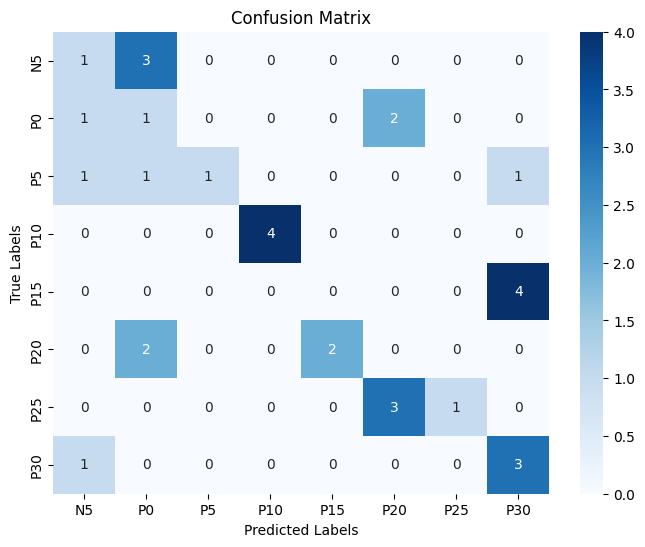

In [102]:
# Individual Testing
from sklearn.metrics import confusion_matrix
import seaborn as sns
subject = 5

pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_test_front[int(subject*8):int(subject*8)+8], loaded_model_jaw, index_subject_to_predict=-1, data_Y=Y_test_front[int(subject*8):int(subject*8)+8])
print(accuracy)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=trials, yticklabels=trials)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Read Jaw Clench EMG Artifact
Extrac files separately and plot only. Machine learning is cells further downt

In [ ]:
# Get EEG and plot
import get_openbci_text
import os
import pandas as pd
import numpy as np
text_array_close = get_openbci_text.import_text_file(os.path.join(
    'data','trial','gtl','jaw_clench','N5.txt'))
eeg_close_array = get_openbci_text.filter_eeg_columns(text_array_close)
eeg_channels = [0,1,2,3,4,5,6,7]
sample_rate = 250

# Print out some information to represent the data
print('Shape of extracted data = {}'.format(eeg_close_array.shape))
print('Length of sample = {} s = {:.3} min'.format(eeg_close_array.shape[2]/sample_rate, eeg_close_array.shape[2]/sample_rate/60))

# Filter signal based on setting in OpenBCI
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt


# Perform BPF and notch filter
low_freq, high_freq, filter_order = 2, 90, 2
bool_band_pass, bool_notch = True, True
filtered_eeg_close = digital_filter.perform_filter(eeg_close_array, band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)

# Filter to use only EEG channels, only use the data denoted below
length_samples_s = 2
length_samples_offset_s = 49
eeg_close = filtered_eeg_close[0,0][:,eeg_channels]   # Shape of (samples, len(eeg_channels))
eeg_close = np.expand_dims(np.expand_dims(eeg_close, axis=0), axis=0)
eeg_close = eeg_close[:,:,int(sample_rate*length_samples_offset_s):int(length_samples_s*sample_rate)+int(sample_rate*length_samples_offset_s),:]
print(filtered_eeg_close.shape, eeg_close.shape)

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,0]+500*6)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,1]+500*5)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,2]+500*4)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,3]+500*3)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,6]+500*2)
plt.plot(np.arange(eeg_close.shape[2])/sample_rate, eeg_close[0,0,:,7]+500)
plt.legend(['Fp1','Fp2','T3','T4','O1','O2'])
plt.show()

# Read Jaw Clench EMG Artifact
Extract, Segment, Augment Data

In [ ]:
# Get EEG and split them to segments of 2s
import get_openbci_text
import os
import pandas as pd
import numpy as np
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process

# Parameters
eeg_channels = [0,1,2,3,4,5,6,7]
sample_rate = 250
low_freq, high_freq, filter_order = 2, 90, 2   # BPF Parameters
bool_band_pass, bool_notch = True, True        # Filter On/Off
num_clench_per_record = 24
segment_len_s = 3
clench_interval_s = 5
offset_s = -0.5

# Read .txt and extract EEG data
text_array = get_openbci_text.import_text_file(os.path.join('freq_cal','EMG','All_3_6cm_Fp12_3_1cm.txt'))
y_label = 0
eeg_array = get_openbci_text.filter_eeg_columns(text_array)
print('Shape of extracted data = {}'.format(eeg_array.shape))  #  Print out some information to represent the data
print('Length of sample = {} s = {:.3} min'.format(eeg_array.shape[2]/sample_rate, eeg_array.shape[2]/sample_rate/60))

# Perform BPF and notch filter
filtered_eeg = digital_filter.perform_filter(eeg_array, band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)

# Split data to 2 sets: Front> Fp1,Fp2,T3,T4; Back>O1,O2,T3,T4
# Channels in original eeg are [Fp1,Fp2,T3,T4,T3_noise,T4_noise,O1,O2]
eeg_front = filtered_eeg[:,:,:,[0,1,2,3]]
eeg_back  = filtered_eeg[:,:,:,[6,7,2,3]]
# eeg_front = filtered_eeg[:,:,:,[0,1]]
# eeg_back  = filtered_eeg[:,:,:,[6,7]]

# Split eeg to 3s intervals: shape from (1,1,250*120,4) to (1,24,250*2,4). For every 5s, 3s of data between is dropped
eeg_front_seg = np.zeros((1,num_clench_per_record,int(sample_rate*segment_len_s),eeg_front.shape[3]))
eeg_back_seg = np.zeros((1,num_clench_per_record,int(sample_rate*segment_len_s),eeg_front.shape[3]))
for i in range(num_clench_per_record):
    eeg_front_seg[0,i] = eeg_front[0,0,int((i+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((i+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
    eeg_back_seg[0,i]  = eeg_back[0,0,int((i+1)*sample_rate*clench_interval_s)+int(offset_s*sample_rate):int((i+1)*sample_rate*clench_interval_s)+int(sample_rate*segment_len_s)+int(offset_s*sample_rate)]
print('eeg_front shape = {}; eeg_front_seg shape = {}'.format(eeg_front.shape, eeg_front_seg.shape))
print('eeg_back shape = {}; eeg_back_seg shape = {}'.format(eeg_back.shape, eeg_back_seg.shape))

# Create Y label
eeg_front_seg_y = np.zeros((1,eeg_front_seg.shape[1],1))
eeg_front_seg_y[:,:,:] = y_label
eeg_back_seg_y = np.zeros((1,eeg_back_seg.shape[1],1))
eeg_back_seg_y[:,:,:]  = y_label

# To randomize the Y label (to check model shouldnt always give so good results)
# eeg_front_seg_y[0,0:8,0]=1
# eeg_front_seg_y[0,8:16,0]=0
# eeg_front_seg_y[0,16:24,0]=2

In [ ]:
# Train-Val Split and Augment Dataset
# For eeg_front
X_train_front, Y_train_front, X_val_front, Y_val_front = pre_process.pre_process_dataset(eeg_front_seg, eeg_front_seg_y, is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)
# For eeg_back
X_train_back, Y_train_back, X_val_back, Y_val_back = pre_process.pre_process_dataset(eeg_back_seg, eeg_back_seg_y, is_train=True, val_pct=0.2, sig_filter=['None', 4, 38, 250], normalize=[False, 1e-3], augment_sample = [True, int(2*sample_rate), 2, int(0.2*sample_rate)], req_unshuffle=False, downsample_factor=1)

In [ ]:
# Consolidate from different trials into train, val set
# Front
X_train_front_31 = np.copy(X_train_front)
Y_train_front_31 = np.copy(Y_train_front)
X_val_front_31 = np.copy(X_val_front)
Y_val_front_31 = np.copy(Y_val_front)

# X_train_front_36 = np.copy(X_train_front)
# Y_train_front_36 = np.copy(Y_train_front)
# X_val_front_36 = np.copy(X_val_front)
# Y_val_front_36 = np.copy(Y_val_front)

# X_train_front_46 = np.copy(X_train_front)
# Y_train_front_46 = np.copy(Y_train_front)
# X_val_front_46 = np.copy(X_val_front)
# Y_val_front_46 = np.copy(Y_val_front)

# Back
X_train_back_31 = np.copy(X_train_back)
Y_train_back_31 = np.copy(Y_train_back)
X_val_back_31 = np.copy(X_val_back)
Y_val_back_31 = np.copy(Y_val_back)

# X_train_back_36 = np.copy(X_train_back)
# Y_train_back_36 = np.copy(Y_train_back)
# X_val_back_36 = np.copy(X_val_back)
# Y_val_back_36 = np.copy(Y_val_back)

# X_train_back_46 = np.copy(X_train_back)
# Y_train_back_46 = np.copy(Y_train_back)
# X_val_back_46 = np.copy(X_val_back)
# Y_val_back_46 = np.copy(Y_val_back)

In [ ]:
# Printout to verify
print(X_train_front_31.shape,X_train_front_36.shape,X_train_front_46.shape)
print(Y_train_front_31.shape,Y_train_front_36.shape,Y_train_front_46.shape)
print(X_val_front_31.shape,X_val_front_36.shape,X_val_front_46.shape)
print(Y_val_front_31.shape,Y_val_front_36.shape,Y_val_front_46.shape)
print(Y_train_front_31[0,0,0], Y_train_front_36[0,0,0], Y_train_front_46[0,0,0])
print(Y_val_front_31[0,0,0], Y_val_front_36[0,0,0], Y_val_front_46[0,0,0])

In [ ]:
# Concatenate the data for training and validation
# Front
X_train_front = np.concatenate((X_train_front_31,X_train_front_36,X_train_front_46),axis=1)
Y_train_front = np.concatenate((Y_train_front_31,Y_train_front_36,Y_train_front_46),axis=1)
X_val_front = np.concatenate((X_val_front_31,X_val_front_36,X_val_front_46),axis=1)
Y_val_front = np.concatenate((Y_val_front_31,Y_val_front_36,Y_val_front_46),axis=1)
print('Train Shape: {} x 3 = {}'.format(X_train_front_31.shape[1], X_train_front_31.shape[1]*3))
print('Val Shape: {} x 3 = {}'.format(X_val_front_31.shape[1], X_val_front_31.shape[1]*3))
print(X_train_front.shape, Y_train_front.shape, X_val_front.shape, Y_val_front.shape)

# Back
X_train_back = np.concatenate((X_train_back_31,X_train_back_36,X_train_back_46),axis=1)
Y_train_back = np.concatenate((Y_train_back_31,Y_train_back_36,Y_train_back_46),axis=1)
X_val_back = np.concatenate((X_val_back_31,X_val_back_36,X_val_back_46),axis=1)
Y_val_back = np.concatenate((Y_val_back_31,Y_val_back_36,Y_val_back_46),axis=1)
print('Train Shape Back: {} x 3 = {}'.format(X_train_back_31.shape[1], X_train_back_31.shape[1]*3))
print('Val Shape Back: {} x 3 = {}'.format(X_val_back_31.shape[1], X_val_back_31.shape[1]*3))
print(X_train_back.shape, Y_train_back.shape, X_val_back.shape, Y_val_back.shape)

# Shuffle entries (if required)
# shuffle_two_arrays_along_axis(X_train_front, Y_train_front, axis=1)
# shuffle_two_arrays_along_axis(X_val_front, Y_val_front, axis=1)

In [ ]:
# Plot eeg_front_seg
index_plt = 300   # 0 to 124
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(X_val_front.shape[2])/sample_rate, X_val_front[0,index_plt,:,0]+500*3)
plt.plot(np.arange(X_val_front.shape[2])/sample_rate, X_val_front[0,index_plt,:,1]+500*2)
plt.plot(np.arange(X_val_front.shape[2])/sample_rate, X_val_front[0,index_plt,:,2]+500*1)
plt.plot(np.arange(X_val_front.shape[2])/sample_rate, X_val_front[0,index_plt,:,3]+500*0)
plt.legend(['Fp1','Fp2','T3','T4'])
plt.show()

In [ ]:
# Plot eeg_back_seg
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(np.arange(X_val_back.shape[2])/sample_rate, X_val_back[0,index_plt,:,0]+500*3)
plt.plot(np.arange(X_val_back.shape[2])/sample_rate, X_val_back[0,index_plt,:,1]+500*2)
plt.plot(np.arange(X_val_back.shape[2])/sample_rate, X_val_back[0,index_plt,:,2]+500*1)
plt.plot(np.arange(X_val_back.shape[2])/sample_rate, X_val_back[0,index_plt,:,3]+500*0)
plt.legend(['O1','O2','T3','T4'])
plt.show()

# Start EEGNet Training

In [ ]:
# Training using standard commands
# from algo.eegnet import run_eegnet
# from algo.eegnet import EEGModels
# import tensorflow as tf

# # Train model
# new_loss = tf.keras.losses.CategoricalCrossentropy(
#     from_logits=False,
#     # label_smoothing=0.0,
#     # axis=-1,
#     reduction=tf.keras.losses.Reduction.NONE,
#     name='categorical_crossentropy'
# )
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# # Reshape objects
# X_train1, Y_train1 = run_eegnet.reshape_on_subject(X_train_front, Y_train_front, -1)
# X_val1, Y_val1 = run_eegnet.reshape_on_subject(X_val_front, Y_val_front, -1)

# # EEGNet Model
# model = EEGModels.EEGNet(nb_classes=Y_train1.shape[1], Chans=X_train1.shape[2], kernLength=256, F1=12, D=2, F2=24, Samples=X_train1.shape[3], regularize=[False, 'L2', 0.001])
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# # Train model
# epoch= 10 #200
# batch_size=256
# history=model.fit(X_train1, Y_train1, epochs=epoch, verbose=1, validation_data=(X_val1, Y_val1), batch_size=batch_size)

In [ ]:
# Cell to save and load array
# X_train_front, Y_train_front, X_val_front, Y_val_front
np.savez('front_2ch_noBPF.npz',X_train_front, Y_train_front, X_val_front, Y_val_front)
np.savez('back_2ch_noBPF.npz',X_train_back, Y_train_back, X_val_back, Y_val_back)

# To load saved file
# loaded=np.load('front.npz')
# print(loaded.files)
# X_train_front = loaded['arr_0']
# Y_train_front = loaded['arr_1']
# X_val_front   = loaded['arr_2']
# Y_val_front   = loaded['arr_3']

In [ ]:
trained_model, history = run_eegnet.train_eegnet(X_train_front, Y_train_front, X_val_front, Y_val_front, index_subject_to_train=0, 
                                        epoch = 20, learning_rate = 0.001, batch_size = 256, F1=12, D = 2, F2=24,
                                        regularize = [False, 'L2', 0.001], model = 'eegnet', kernLength=256)
# trained_model, history = run_eegnet.train_eegnet(X_train_front, Y_train_front, X_val_front, Y_val_front, index_subject_to_train=0, 
#                                         epoch = 50, learning_rate = 0.001, batch_size = 256, F1=50, D = 2, F2=240,
#                                         regularize = [False, 'L2', 0.001], model = 'eegnet',kernLength=256)
print('Final test accuracy = {}, Final val accuracy = {}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
pred_Y, truth_Y, accuracy = run_eegnet.predict_evaluate(X_val_front, trained_model, index_subject_to_predict=0, data_Y=Y_val_front)

# Get confusioni Matrix
cm = confusion_matrix(truth_Y, pred_Y)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def shuffle_two_arrays_along_axis(arr1, arr2, axis=0):
    if axis == 0:
        # Generate a random permutation of indices
        permutation = np.random.permutation(arr1.shape[axis])
        # Apply the permutation to both arrays
        arr1[:] = arr1[permutation]
        arr2[:] = arr2[permutation]
    else:
        # Transpose the arrays so that the axis of interest becomes the first axis
        transposed1 = np.swapaxes(arr1, 0, axis)
        transposed2 = np.swapaxes(arr2, 0, axis)
        # Generate a random permutation of indices
        permutation = np.random.permutation(transposed1.shape[0])
        # Apply the permutation to both transposed arrays
        transposed1[:] = transposed1[permutation]
        transposed2[:] = transposed2[permutation]
        # Transpose back to the original shape
        arr1[:] = np.swapaxes(transposed1, 0, axis)
        arr2[:] = np.swapaxes(transposed2, 0, axis)
shuffle_two_arrays_along_axis(X_val_front, Y_val_front, axis=1)

In [ ]:
trained_model, history = run_eegnet.train_eegnet(X_train_back, Y_train_back, X_val_back, Y_val_back, index_subject_to_train=0, 
                                        epoch = 20, learning_rate = 0.001, batch_size = 256, F1=12, D = 2, F2=24,
                                        regularize = [False, 'L2', 0.001], model = 'eegnet')
print('Final test accuracy = {}, Final val accuracy = {}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

In [ ]:
model.summary()

In [ ]:
# Get EEG and plot
import get_openbci_text
import os
import pandas as pd
import numpy as np
text_array_close = get_openbci_text.import_text_file(os.path.join('EEG_w_audio','80Hz_4.txt'))
eeg_close_array = get_openbci_text.filter_eeg_columns(text_array_close)
eeg_channels = [5,6,7]
sample_rate = 250

# Print out some information to represent the data
print('Shape of extracted data = {}'.format(eeg_close_array.shape))
print('Length of sample = {} s = {:.3} min'.format(eeg_close_array.shape[2]/sample_rate, eeg_close_array.shape[2]/sample_rate/60))

# Filter signal based on setting in OpenBCI
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt


# Perform BPF and notch filter
low_freq, high_freq, filter_order = 5, 120, 2
filtered_eeg_close = digital_filter.perform_filter(eeg_close_array, band_pass=[True, low_freq, high_freq, filter_order], notch_filter=True, sampling_freq = sample_rate)

# Filter to use only EEG channels, only use the last 1min of data
length_samples_min = 0.7  # Approx 42s
eeg_close = filtered_eeg_close[0,0][:,eeg_channels]   # Shape of (samples, len(eeg_channels))
eeg_close = np.expand_dims(np.expand_dims(eeg_close, axis=0), axis=0)
eeg_close = eeg_close[:,:,250*3:int(length_samples_min*60*sample_rate)+250*3,:]
print(filtered_eeg_close.shape, eeg_close.shape)

# Apply FFT and plot
import matplotlib.pyplot as plt
xf_close, yf_close = apply_fft(eeg_close, spectrum_type='amplitude', amp_scale='linear', filter_bin = [False, sample_rate, 10, 60])
print(xf_close.shape,yf_close.shape)

xf_close_0, yf_close_0 = get_avg_fft_bins(xf_close, yf_close[0,0,:,0], num_of_bins_to_combine=2)
xf_close_1, yf_close_1 = get_avg_fft_bins(xf_close, yf_close[0,0,:,1], num_of_bins_to_combine=2)
xf_close_2, yf_close_2 = get_avg_fft_bins(xf_close, yf_close[0,0,:,2], num_of_bins_to_combine=2)

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(xf_close_0, yf_close_0)
plt.plot(xf_close_1, yf_close_1)
plt.plot(xf_close_2, yf_close_2)
# plt.plot(xf_close, yf_close[0,0,:,0])
# plt.plot(xf_close, yf_close[0,0,:,1])
# plt.plot(xf_close, yf_close[0,0,:,2])
plt.legend(['Noise T7', 'Noise T8', 'T7'])
# plt.xlim([55,65])
plt.xlim([75,85])
plt.xlim([85,95])
plt.xlim([25,26])
plt.ylim([8, 11])
plt.show()

# Generate single tone

In [ ]:
# From https://stackoverflow.com/questions/8299303/generating-sine-wave-sound-in-python
# Frequency of sine is what is detected
import time

import numpy as np
import pyaudio

p = pyaudio.PyAudio()

volume = 0.7  # range [0.0, 1.0]
fs = 44100  # sampling rate, Hz, must be integer
duration = 5.0  # in seconds, may be float
f = 110.0  # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
samples = (np.sin(2 * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)
print('shape of samples = {}'.format(samples.shape))

# per @yahweh comment explicitly convert to bytes sequence
output_bytes = (volume * samples).tobytes()

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively)
start_time = time.time()
stream.write(output_bytes)
print("Played sound for {:.2f} seconds".format(time.time() - start_time))

stream.stop_stream()
stream.close()

p.terminate()

In [ ]:
# # Audio generation
# import math        #import needed modules
# import pyaudio     #sudo apt-get install python-pyaudio
# PyAudio = pyaudio.PyAudio     #initialize pyaudio
# BITRATE = 16000   # 5000     #number of frames per second/frameset.
# FREQUENCY = 20     #Hz, waves per second, 261.63=C4-note.
# LENGTH = 10    #seconds to play sound
# if FREQUENCY > BITRATE:
#     BITRATE = FREQUENCY+100
# NUMBEROFFRAMES = int(BITRATE * LENGTH)
# RESTFRAMES = NUMBEROFFRAMES % BITRATE
# WAVEDATA = ''
# #generating waves
# for x in range(NUMBEROFFRAMES):
#      WAVEDATA = WAVEDATA+chr(int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128))
        
# for x in range(RESTFRAMES):
#     WAVEDATA = WAVEDATA+chr(128)
# # print(WAVEDATA)
# p = PyAudio()
# stream = p.open(format = p.get_format_from_width(1),channels = 2,rate = BITRATE,output = True)
# stream.write(WAVEDATA)
# stream.stop_stream()
# stream.close()
# p.terminate()

# Checking Time Resolution

In [ ]:
from time import (
    process_time,
    perf_counter,
    sleep,
)

print(process_time())
sleep(1)
print(process_time())

print(perf_counter())
sleep(1)
print(perf_counter())

In [ ]:
import time

time_ns = time.monotonic_ns()
sleep(1)
time2_ns = time.monotonic_ns()
print((time2_ns-time_ns-1e9))

In [ ]:
import time

time_ns = time.perf_counter_ns() 
# sleep(1)
for i in range(int(1e5)):
    a = 1e9 / 5e6
time2_ns = time.perf_counter_ns() 
print((time2_ns-time_ns)/1e6, ' ms')


In [ ]:
import time

time_ns = time.process_time_ns() 
for i in range(int(1e5)):
    a = 1e9 / 5e6
time2_ns = time.process_time_ns() 
print((time2_ns-time_ns)/1e6, ' ms')

# Listen to keyboard input

In [ ]:
import keyboard
import time

while True:
    if keyboard.is_pressed('space'):  # if 'q' key is pressed 
        print('You Pressed Space Key at {}ns!'.format(time.monotonic_ns()))
        break  # exit the loop

In [ ]:
14052281000000/1e9

# Read OpenBCI text File into data structure and visualize them

In [ ]:
def rms(input_array):
    """
    Function to get rms of input_array.
    Argument:
        input_array: type np.ndarray of shape (n,)
    Return:
        rms: type float. rms of input_array
    """
    square = np.square(input_array)
    mean_sq = np.mean(square)
    rms = np.sqrt(mean_sq)
    return rms

def get_sample_from_file(file_name, 
                         directory='dist_freq_amp',
                         channel_num=0,
                         sample_rate=250,
                         start_time_s=4,
                         end_time_s=14,
                         band_pass=[True,18,20,4],
                         notch_filter=True,
                         ):
    """
    band_pass=[True, low_freq, high_freq, filter_order], notch_filter=True, 
    Function to get the amplitude-time files from the input text. 
    Argument:
        file_name: type str. Input file name in .txt file format. Output of OpenBCI GUI
        band_pass: type lst of len 4. 
            band_pass[0]: type bool. Indicate if require band_pass filter. True=need
            band_pass[1]: type int. Low freq of the BPF
            band_pass[2]: type int. High freq of the BPF
            band_pass[3]: type int. Order of BPF
        notch_filter: type bool. If True, denote the presence of notch filter. 
    Return:
        eeg_amp_time: type np.ndarray of shape (n,) where n is the number of samples in the time duration from start to end.
        rms_output: type float. The rms of the eeg_amp_time output signal
    """
    import get_openbci_text
    import os
    import pandas as pd
    import numpy as np
    import digital_filter
    import analysis
    
    # Extract data from .txt file
    text_array = get_openbci_text.import_text_file(os.path.join(directory,file_name))
    eeg_array = get_openbci_text.filter_eeg_columns(text_array)
#     print('Shape of extracted data = {}'.format(eeg_array.shape))
    
    # BPF and notch filter
    filtered_eeg_array = digital_filter.perform_filter(eeg_array,band_pass=band_pass,notch_filter=notch_filter,sampling_freq=sample_rate)
    
    # Filter based on start_time_s:end_time_s and channel_num
    eeg_amp_time = filtered_eeg_array[0,0,int(start_time_s*sample_rate):int(end_time_s*sample_rate),channel_num]
#     print('Shape of output data = {}'.format(eeg_amp_time.shape))
    
    # Get rms of signal in the band_pass filter band
    rms_output = rms(eeg_amp_time)
    
    return eeg_amp_time, rms_output

In [ ]:
# Read all recorded .txt files into the dictionary data[dist][freq][is_rms]
data={}   # data in format data[dist][freq][is_rms]. is_rms=0: means is eeg data. is_rms=1: means is rms output of eeg
for dist in range(2,7):
    for freq in range(20,100,10):
        # Get data with filtering
        file_str = 'D'+str(dist)+'_F'+str(freq)+'.txt'
        eeg_amp_time, rms_output = get_sample_from_file(file_str, band_pass=[True,freq-2,freq+2,4])
        print('Read File with Name = {}'.format(file_str))

        # Put data in dict format
        if dist not in data:
            data[dist] = {}
        data[dist][freq]={}
        data[dist][freq][0]=eeg_amp_time
        data[dist][freq][1]=rms_output      

In [ ]:
np.log

In [ ]:
# Function to plot the extracted rms values into a scatter plot

# Prepare list for plotting 
dists = list(data.keys())

plt_freqs = []
plt_dists = []
plt_rms = []
for dist in dists:
    freqs = list(data[dist].keys())
    for freq in freqs:
        plt_freqs.append(freq)
        plt_dists.append(dist)
        plt_rms.append(data[dist][freq][1])
        
# Plotting
plt.figure(figsize=(10, 6))
for freq, dist, rms in zip(plt_freqs, plt_dists, plt_rms):
#     plt.scatter(freq, dist, c='blue', s=rms*10)  # size of point is proportional to amplitude
#     plt.scatter(plt_freqs, plt_dists, c=plt_rms)  # size of point is proportional to amplitude
    plt.scatter(plt_freqs, plt_dists, c=plt_rms, s=[x * 5 for x in plt_rms])  # size of point is proportional to amplitude
    

plt.xlabel('Frequency (Hz)')
plt.ylabel('Distance (cm)')
plt.title('Frequency vs Distance with RMS Amplitude Indication')
plt.colorbar(label='Amplitude')
# plt.colorbar(label='Log10(Amplitude)')
plt.grid(True)
plt.show()

In [ ]:
# For a chosen frequency, plot its rms amplitude Vs distance
freq = 30  # From 20-90Hz, in 10Hz resolution
plt_dist = list(data.keys())
plt_rms = []
for dist in plt_dist:
    plt_rms.append(data[dist][freq][1])

# Plot
plt.plot(plt_dist, plt_rms)
plt.xlabel('Distance from ear-piece')
plt.ylabel('EEG RMS Amplitude (uV)')
plt.title('Plot of EEG RMS Amplitude Vs Distance from Ear-piece for freq {}Hz'.format(freq))
plt.show()

In [ ]:
# For a chosen dist, plot its rms amplitude Vs freq
dist = 4  # From 2-6cm, in 1cm resolution
plt_freq = list(data[dist].keys())
plt_rms = []
for freq in plt_freq:
    plt_rms.append(data[dist][freq][1])

# Plot
plt.plot(plt_freq, plt_rms)
plt.xlabel('Frequency of signal (Hz)')
plt.ylabel('EEG RMS Amplitude (uV)')
plt.title('Plot of EEG RMS Amplitude Vs Signal Freq for Distance {}cm from ear-piece'.format(dist))
plt.show()

In [ ]:
# Plot EEG signal
freq1, freq2 = 30, 80 # From 20-90Hz, in 10Hz resolution
dist1, dist2 = 4, 4  # From 2-6cm, in 1cm resolution
time_start_s = 0   # From 0 - 10s
time_end_s = 2   # From 0 - 10s

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data[dist1][freq1][0][int(time_start_s*250):int(time_end_s*250)])   # Plot first eeg with dist1, freq1
plt.plot(data[dist2][freq2][0][int(time_start_s*250):int(time_end_s*250)])   # Plot second eeg with dist2, freq2
plt.legend(['Freq={}, Dist={}'.format(freq1,dist1),'Freq={}, Dist={}'.format(freq2,dist2)])
plt.title('Plot of EEG data for time {}s to {}s'.format(time_start_s, time_end_s))
plt.show()

In [ ]:
# Check EEG recording, set crazy channels to 0
import get_openbci_text
import os
import pandas as pd
import numpy as np
import digital_filter
import analysis
import matplotlib.pyplot as plt
import pre_process
from algo.eegnet import run_eegnet
# Parameters
low_freq, high_freq, filter_order = 5, 90, 2
bool_band_pass, bool_notch = True, True 
sample_rate = 250
offset_s = 2
trials = ['N5','P0','P5']
notes = ['A0','C1','E1','B1','D2','E2','F2']  # 'A0','C1','E1','B1','D2','E2','F2'
eyes = ['open','close']
# subjects = ['gtl','gtl2','wife','ayanga','yash']
subjects = ['sis']
total_duration_s = 25

# Get data and perform BPF
for m, subject in enumerate(subjects): 
    array = dict()
    filtered_array = dict()
    for i,trial in enumerate(trials):
        array[i]=dict()
        filtered_array[i]=dict()
        for j,note in enumerate(notes):
            array[i][j]=dict()
            filtered_array[i][j]=dict()
            for k,eye in enumerate(eyes):
                array[i][j][k] = get_openbci_text.import_text_file(os.path.join('data','trial',subject,'conduction',trial+'_'+note+'_'+eye+'.txt'))
                array[i][j][k] = get_openbci_text.filter_eeg_columns(array[i][j][k])
                filtered_array[i][j][k] = digital_filter.perform_filter(array[i][j][k], band_pass=[bool_band_pass, low_freq, high_freq, filter_order], notch_filter=bool_notch, sampling_freq = sample_rate)
                # print('Data for {}_{}_{}.txt of shape {}'.format(trial,note,eye,filtered_array[i][j][k].shape))
    
    # Reshape data to eeg_seg with shape=(n_trial, n_notes*n_eyes, sample_rate*total_duration_s, channels)
    eeg_seg = np.zeros((len(trials),len(notes)*len(eyes),int(sample_rate*total_duration_s),filtered_array[0][0][0].shape[3]))
    for i in range(len(trials)):
        for j in range(len(notes)):
            for k in range(len(eyes)):
                eeg_seg[i,j*len(eyes)+k] = filtered_array[i][j][k][0,0,int(sample_rate*offset_s):int(sample_rate*offset_s)+int(sample_rate*total_duration_s)]
    print('eeg_seg has shape = {}'.format(eeg_seg.shape))
    if m == 0:
        X_T3 = np.copy(eeg_seg)
        X_T4 = np.copy(eeg_seg)
        print('m=0. X_T3 shape = {}'.format(X_T3.shape))
    else:
        X_T3 = np.concatenate((X_T3, np.copy(eeg_seg)), axis=0)
        X_T4 = np.concatenate((X_T4, np.copy(eeg_seg)), axis=0)
        print('m else. X_T3 shape = {}'.format(X_T3.shape))
    
    # Create y label
    Y_T3_temp = np.zeros((len(trials),len(notes)*len(eyes),1))
    Y_T4_temp = np.zeros((len(trials),len(notes)*len(eyes),1))
    for i, trial in enumerate(trials):
        Y_T3_temp[i,:,:] = i
        Y_T4_temp[i,:,:] = i
    if m == 0:
        Y_T3 = np.copy(Y_T3_temp)
        Y_T4 = np.copy(Y_T4_temp)
    else:
        Y_T3 = np.concatenate((Y_T3, np.copy(Y_T3_temp)), axis=0)
        Y_T4 = np.concatenate((Y_T4, np.copy(Y_T4_temp)), axis=0)
    print('Y_T3 has shape = {}; Y_T4 has shape = {}'.format(Y_T3.shape, Y_T4.shape))


In [ ]:
import numpy as np

def clean_eeg(data, window_size=10, threshold=100):
    """
    Function to clean EEG signal by thresholding method. 
    Calculates the RMS amplitude of window_size samples, and set the sample to 0 if the RMS amplitude exceeds threshold.
    Input:
        data: type np.ndarray of shape (trial, freq_eyestate, samples, channels)
        window_size: type int. Number of samples to use for RMS calculation
        threshold: type int. Threshold amplitude value in uV
    Output: :
        clean_data: type np.ndarray of shape (trial, freq_eyestate, samples, channels)
        indices: type list. List of samples with RMS exceeding threshold.
    """
    # Function to calculate RMS across a sliding window
    def sliding_rms(data, window_size):
        # Squaring the data
        squared_data = np.square(data)
        
        # Calculating moving average using a sliding window
        moving_average = np.convolve(squared_data, np.ones(window_size), 'valid') / window_size
        
        # Taking the square root of the moving average
        rms = np.sqrt(moving_average)
        return rms
    
    # Applying the RMS function to your data
    # X_T3 = np.random.rand(18, 14, 6250, 8)  # Example data, replace with your actual array
    window_size = 10
    threshold = 100
    X_T3_cleaned = np.copy(X_T3)
    
    # Preparing an array to store the indices
    indices = []
    
    # Loop through the dimensions except the third (samples dimension)
    for i in range(X_T3.shape[0]):
        for j in range(X_T3.shape[1]):
            for k in range(X_T3.shape[3]):
                # Calculate RMS for each 1D segment
                rms_values = sliding_rms(X_T3[i, j, :, k], window_size)
                
                # Find indices where RMS exceeds the threshold
                exceed_indices = np.where(rms_values > threshold)[0] + (window_size // 2)  # Adjust indices for the window
                
                # Store the indices along with the other dimensions
                for idx in exceed_indices:
                    indices.append((i, j, idx, k))
                    
                    # Ensuring the window stays within the bounds of the data
                    start_index = max(idx - window_size , 0)  # start_index = max(idx - window_size // 2, 0)
                    end_index = min(idx + window_size + 1, X_T3.shape[2])  # end_index = min(idx + window_size // 2 + 1, X_T3.shape[2])
                    X_T3_cleaned[i, j, start_index:end_index, k] = 0

    return X_T3_cleaned, indices
X_T3_cleaned, indices = clean_eeg(X_T3)

In [ ]:
X_T3_cleaned, indices = clean_eeg(X_T3)

In [ ]:
# indices[200:300]

In [ ]:
trial_num, freq_eye_num, channel = 0, 0, 1
plt.plot(X_T3[trial_num,freq_eye_num,:,channel])

In [ ]:
plt.plot(X_T3_cleaned[trial_num,freq_eye_num,:,channel])

In [ ]:
X_T3.shape

In [ ]:
18/3

In [ ]:
# print(Y_train_T3.shape)
# # For subject 1, of each 250 trials, replace 40 x 5 = 200 from other participants
# # Do that for the training set only
# Y_train_T3_new = np.copy(Y_train_T3)
# X_train_T3_new = np.copy(X_train_T3)
# for subject in range(3):
#     # Person 1
#     # Y_train_T3_new[subject:subject+1,0:40,:] = Y_train_T3[subject+3:subject+1+3,0:40,:]
#     # Y_train_T3_new[subject:subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[subject:subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[subject:subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[subject:subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[subject:subject+1,0:40,:] = X_train_T3[subject+3:subject+1+3,0:40,:]
#     # X_train_T3_new[subject:subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[subject:subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[subject:subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[subject:subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[subject:subject+1,0:40,:] = Y_train_T3[subject+3:subject+1+3,0:40,:]
#     # Y_train_T3_new[subject:subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[subject:subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[subject:subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[subject:subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[subject:subject+1,0:40,:] = X_train_T3[subject+3:subject+1+3,0:40,:]
#     # X_train_T3_new[subject:subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[subject:subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[subject:subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[subject:subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 2
#     # Y_train_T3_new[3+subject:3+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[3+subject:3+subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[3+subject:3+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[3+subject:3+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[3+subject:3+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[3+subject:3+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[3+subject:3+subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[3+subject:3+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[3+subject:3+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[3+subject:3+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[3+subject:3+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[3+subject:3+subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[3+subject:3+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[3+subject:3+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[3+subject:3+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[3+subject:3+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[3+subject:3+subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[3+subject:3+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[3+subject:3+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[3+subject:3+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 3
#     # Y_train_T3_new[6+subject:6+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[6+subject:6+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[6+subject:6+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[6+subject:6+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[6+subject:6+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[6+subject:6+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[6+subject:6+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[6+subject:6+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[6+subject:6+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[6+subject:6+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[6+subject:6+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[6+subject:6+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[6+subject:6+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[6+subject:6+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[6+subject:6+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[6+subject:6+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[6+subject:6+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[6+subject:6+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[6+subject:6+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[6+subject:6+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 4
#     # Y_train_T3_new[9+subject:9+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[9+subject:9+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[9+subject:9+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[9+subject:9+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[9+subject:9+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[9+subject:9+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[9+subject:9+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[9+subject:9+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[9+subject:9+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[9+subject:9+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[9+subject:9+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[9+subject:9+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[9+subject:9+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[9+subject:9+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[9+subject:9+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[9+subject:9+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[9+subject:9+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[9+subject:9+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[9+subject:9+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[9+subject:9+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 5
#     # Y_train_T3_new[12+subject:12+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[12+subject:12+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[12+subject:12+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[12+subject:12+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     # Y_train_T3_new[12+subject:12+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[12+subject:12+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[12+subject:12+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[12+subject:12+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[12+subject:12+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     # X_train_T3_new[12+subject:12+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[12+subject:12+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[12+subject:12+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[12+subject:12+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[12+subject:12+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     # Y_train_T3_new[12+subject:12+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[12+subject:12+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[12+subject:12+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[12+subject:12+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[12+subject:12+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     # X_train_T3_new[12+subject:12+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 6
#     Y_train_T3_new[15+subject:15+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     Y_train_T3_new[15+subject:15+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     Y_train_T3_new[15+subject:15+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     Y_train_T3_new[15+subject:15+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     Y_train_T3_new[15+subject:15+subject+1,160:200,:] = Y_train_T3[subject+12:subject+1+12,160:200,:]
    
#     X_train_T3_new[15+subject:15+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     X_train_T3_new[15+subject:15+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     X_train_T3_new[15+subject:15+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     X_train_T3_new[15+subject:15+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     X_train_T3_new[15+subject:15+subject+1,160:200,:] = X_train_T3[subject+12:subject+1+12,160:200,:]

#     Y_train_T3_new[15+subject:15+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     Y_train_T3_new[15+subject:15+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     Y_train_T3_new[15+subject:15+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     Y_train_T3_new[15+subject:15+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     Y_train_T3_new[15+subject:15+subject+1,160:200,:] = Y_train_T3[subject+12:subject+1+12,160:200,:]
    
#     X_train_T3_new[15+subject:15+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     X_train_T3_new[15+subject:15+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     X_train_T3_new[15+subject:15+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     X_train_T3_new[15+subject:15+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     X_train_T3_new[15+subject:15+subject+1,160:200,:] = X_train_T3[subject+12:subject+1+12,160:200,:]

# np.save(os.path.join('data','trial','X_train_T3_6.npy'),X_train_T3_new)
# np.save(os.path.join('data','trial','Y_train_T3_6.npy'),Y_train_T3_new)

# print(X_train_T3[15:18,160:161,:3,0])
# print(X_train_T3_new[15:18,160:161,:3,0])
# print(X_train_T3[12:15,160:161,:3,0])

# # print(X_train_T3[9:12,200:201,:3,0])
# # print(X_train_T3_new[9:12,200:201,:3,0])
# # print(X_train_T3[3:6,40:41,:3,0])

In [ ]:
# print(Y_train_T3.shape)
# # For subject 1, of each 250 trials, replace 40 x 5 = 200 from other participants
# # Do that for the training set only
# Y_train_T3_new = np.copy(Y_train_T3)
# X_train_T3_new = np.copy(X_train_T3)
# for subject in range(3):
#     # Person 1
#     # Y_train_T3_new[subject:subject+1,0:40,:] = Y_train_T3[subject+3:subject+1+3,0:40,:]
#     # Y_train_T3_new[subject:subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[subject:subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[subject:subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[subject:subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[subject:subject+1,0:40,:] = X_train_T3[subject+3:subject+1+3,0:40,:]
#     # X_train_T3_new[subject:subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[subject:subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[subject:subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[subject:subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[subject:subject+1,0:40,:] = Y_train_T3[subject+3:subject+1+3,0:40,:]
#     # Y_train_T3_new[subject:subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[subject:subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[subject:subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[subject:subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[subject:subject+1,0:40,:] = X_train_T3[subject+3:subject+1+3,0:40,:]
#     # X_train_T3_new[subject:subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[subject:subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[subject:subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[subject:subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 2
#     # Y_train_T3_new[3+subject:3+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[3+subject:3+subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[3+subject:3+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[3+subject:3+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[3+subject:3+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[3+subject:3+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[3+subject:3+subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[3+subject:3+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[3+subject:3+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[3+subject:3+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[3+subject:3+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[3+subject:3+subject+1,40:80,:] = Y_train_T3[subject+6:subject+1+6,40:80,:]
#     # Y_train_T3_new[3+subject:3+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[3+subject:3+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[3+subject:3+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[3+subject:3+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[3+subject:3+subject+1,40:80,:] = X_train_T3[subject+6:subject+1+6,40:80,:]
#     # X_train_T3_new[3+subject:3+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[3+subject:3+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[3+subject:3+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 3
#     # Y_train_T3_new[6+subject:6+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[6+subject:6+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[6+subject:6+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[6+subject:6+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[6+subject:6+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[6+subject:6+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[6+subject:6+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[6+subject:6+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[6+subject:6+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[6+subject:6+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[6+subject:6+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[6+subject:6+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[6+subject:6+subject+1,80:120,:] = Y_train_T3[subject+9:subject+1+9,80:120,:]
#     # Y_train_T3_new[6+subject:6+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[6+subject:6+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[6+subject:6+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[6+subject:6+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[6+subject:6+subject+1,80:120,:] = X_train_T3[subject+9:subject+1+9,80:120,:]
#     # X_train_T3_new[6+subject:6+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[6+subject:6+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 4
#     # Y_train_T3_new[9+subject:9+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[9+subject:9+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[9+subject:9+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[9+subject:9+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[9+subject:9+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[9+subject:9+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[9+subject:9+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[9+subject:9+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[9+subject:9+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[9+subject:9+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[9+subject:9+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[9+subject:9+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[9+subject:9+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[9+subject:9+subject+1,120:160,:] = Y_train_T3[subject+12:subject+1+12,120:160,:]
#     # Y_train_T3_new[9+subject:9+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[9+subject:9+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[9+subject:9+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[9+subject:9+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[9+subject:9+subject+1,120:160,:] = X_train_T3[subject+12:subject+1+12,120:160,:]
#     # X_train_T3_new[9+subject:9+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 5
#     # Y_train_T3_new[12+subject:12+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[12+subject:12+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[12+subject:12+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[12+subject:12+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     # Y_train_T3_new[12+subject:12+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[12+subject:12+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[12+subject:12+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[12+subject:12+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[12+subject:12+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     # X_train_T3_new[12+subject:12+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # Y_train_T3_new[12+subject:12+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     # Y_train_T3_new[12+subject:12+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     # Y_train_T3_new[12+subject:12+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     # Y_train_T3_new[12+subject:12+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     # Y_train_T3_new[12+subject:12+subject+1,160:200,:] = Y_train_T3[subject+15:subject+1+15,160:200,:]
    
#     # X_train_T3_new[12+subject:12+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     # X_train_T3_new[12+subject:12+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     # X_train_T3_new[12+subject:12+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     # X_train_T3_new[12+subject:12+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     # X_train_T3_new[12+subject:12+subject+1,160:200,:] = X_train_T3[subject+15:subject+1+15,160:200,:]

#     # # Person 6
#     Y_train_T3_new[15+subject:15+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     Y_train_T3_new[15+subject:15+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     Y_train_T3_new[15+subject:15+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     Y_train_T3_new[15+subject:15+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     Y_train_T3_new[15+subject:15+subject+1,160:200,:] = Y_train_T3[subject+12:subject+1+12,160:200,:]
    
#     X_train_T3_new[15+subject:15+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     X_train_T3_new[15+subject:15+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     X_train_T3_new[15+subject:15+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     X_train_T3_new[15+subject:15+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     X_train_T3_new[15+subject:15+subject+1,160:200,:] = X_train_T3[subject+12:subject+1+12,160:200,:]

#     Y_train_T3_new[15+subject:15+subject+1,0:40,:] = Y_train_T3[subject+0:subject+1+0,0:40,:]
#     Y_train_T3_new[15+subject:15+subject+1,40:80,:] = Y_train_T3[subject+3:subject+1+3,40:80,:]
#     Y_train_T3_new[15+subject:15+subject+1,80:120,:] = Y_train_T3[subject+6:subject+1+6,80:120,:]
#     Y_train_T3_new[15+subject:15+subject+1,120:160,:] = Y_train_T3[subject+9:subject+1+9,120:160,:]
#     Y_train_T3_new[15+subject:15+subject+1,160:200,:] = Y_train_T3[subject+12:subject+1+12,160:200,:]
    
#     X_train_T3_new[15+subject:15+subject+1,0:40,:] = X_train_T3[subject+0:subject+1+0,0:40,:]
#     X_train_T3_new[15+subject:15+subject+1,40:80,:] = X_train_T3[subject+3:subject+1+3,40:80,:]
#     X_train_T3_new[15+subject:15+subject+1,80:120,:] = X_train_T3[subject+6:subject+1+6,80:120,:]
#     X_train_T3_new[15+subject:15+subject+1,120:160,:] = X_train_T3[subject+9:subject+1+9,120:160,:]
#     X_train_T3_new[15+subject:15+subject+1,160:200,:] = X_train_T3[subject+12:subject+1+12,160:200,:]

# np.save(os.path.join('data','trial','X_train_T3_6.npy'),X_train_T3_new)
# np.save(os.path.join('data','trial','Y_train_T3_6.npy'),Y_train_T3_new)

# print(X_train_T3[15:18,160:161,:3,0])
# print(X_train_T3_new[15:18,160:161,:3,0])
# print(X_train_T3[12:15,160:161,:3,0])

# # print(X_train_T3[9:12,200:201,:3,0])
# # print(X_train_T3_new[9:12,200:201,:3,0])
# # print(X_train_T3[3:6,40:41,:3,0])

In [ ]:
print(Y_train_T3.shape)
# For subject 1, of each 250 trials, replace 40 x 5 = 200 from other participants
# Do that for the training set only
Y_train_T3_new = np.copy(Y_train_T3)
X_train_T3_new = np.copy(X_train_T3)
for subject in range(3):
    # Person 1
    # Y_train_T3_new[subject:subject+1,0:20,:] = Y_train_T3[subject+3:subject+1+3,0:20,:]
    # Y_train_T3_new[subject:subject+1,20:40,:] = Y_train_T3[subject+6:subject+1+6,20:40,:]
    # Y_train_T3_new[subject:subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[subject:subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[subject:subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[subject:subject+1,0:20,:] = X_train_T3[subject+3:subject+1+3,0:20,:]
    # X_train_T3_new[subject:subject+1,20:40,:] = X_train_T3[subject+6:subject+1+6,20:40,:]
    # X_train_T3_new[subject:subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[subject:subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[subject:subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # Y_train_T3_new[subject:subject+1,0:20,:] = Y_train_T3[subject+3:subject+1+3,0:20,:]
    # Y_train_T3_new[subject:subject+1,20:40,:] = Y_train_T3[subject+6:subject+1+6,20:40,:]
    # Y_train_T3_new[subject:subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[subject:subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[subject:subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[subject:subject+1,0:20,:] = X_train_T3[subject+3:subject+1+3,0:20,:]
    # X_train_T3_new[subject:subject+1,20:40,:] = X_train_T3[subject+6:subject+1+6,20:40,:]
    # X_train_T3_new[subject:subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[subject:subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[subject:subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # # Person 2
    # Y_train_T3_new[3+subject:3+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[3+subject:3+subject+1,20:40,:] = Y_train_T3[subject+6:subject+1+6,20:40,:]
    # Y_train_T3_new[3+subject:3+subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[3+subject:3+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[3+subject:3+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[3+subject:3+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[3+subject:3+subject+1,20:40,:] = X_train_T3[subject+6:subject+1+6,20:40,:]
    # X_train_T3_new[3+subject:3+subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[3+subject:3+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[3+subject:3+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # Y_train_T3_new[3+subject:3+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[3+subject:3+subject+1,20:40,:] = Y_train_T3[subject+6:subject+1+6,20:40,:]
    # Y_train_T3_new[3+subject:3+subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[3+subject:3+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[3+subject:3+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[3+subject:3+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[3+subject:3+subject+1,20:40,:] = X_train_T3[subject+6:subject+1+6,20:40,:]
    # X_train_T3_new[3+subject:3+subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[3+subject:3+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[3+subject:3+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # # Person 3
    # Y_train_T3_new[6+subject:6+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[6+subject:6+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[6+subject:6+subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[6+subject:6+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[6+subject:6+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[6+subject:6+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[6+subject:6+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[6+subject:6+subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[6+subject:6+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[6+subject:6+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # Y_train_T3_new[6+subject:6+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[6+subject:6+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[6+subject:6+subject+1,40:60,:] = Y_train_T3[subject+9:subject+1+9,40:60,:]
    # Y_train_T3_new[6+subject:6+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[6+subject:6+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[6+subject:6+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[6+subject:6+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[6+subject:6+subject+1,40:60,:] = X_train_T3[subject+9:subject+1+9,40:60,:]
    # X_train_T3_new[6+subject:6+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[6+subject:6+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # # Person 4
    # Y_train_T3_new[9+subject:9+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[9+subject:9+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[9+subject:9+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    # Y_train_T3_new[9+subject:9+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[9+subject:9+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[9+subject:9+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[9+subject:9+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[9+subject:9+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    # X_train_T3_new[9+subject:9+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[9+subject:9+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # Y_train_T3_new[9+subject:9+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[9+subject:9+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[9+subject:9+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    # Y_train_T3_new[9+subject:9+subject+1,60:80,:] = Y_train_T3[subject+12:subject+1+12,60:80,:]
    # Y_train_T3_new[9+subject:9+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[9+subject:9+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[9+subject:9+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[9+subject:9+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    # X_train_T3_new[9+subject:9+subject+1,60:80,:] = X_train_T3[subject+12:subject+1+12,60:80,:]
    # X_train_T3_new[9+subject:9+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # # Person 5
    # Y_train_T3_new[12+subject:12+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[12+subject:12+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[12+subject:12+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    # Y_train_T3_new[12+subject:12+subject+1,60:80,:] = Y_train_T3[subject+9:subject+1+9,60:80,:]
    # Y_train_T3_new[12+subject:12+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[12+subject:12+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[12+subject:12+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[12+subject:12+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    # X_train_T3_new[12+subject:12+subject+1,60:80,:] = X_train_T3[subject+9:subject+1+9,60:80,:]
    # X_train_T3_new[12+subject:12+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # Y_train_T3_new[12+subject:12+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    # Y_train_T3_new[12+subject:12+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    # Y_train_T3_new[12+subject:12+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    # Y_train_T3_new[12+subject:12+subject+1,60:80,:] = Y_train_T3[subject+9:subject+1+9,60:80,:]
    # Y_train_T3_new[12+subject:12+subject+1,80:100,:] = Y_train_T3[subject+15:subject+1+15,80:100,:]
    
    # X_train_T3_new[12+subject:12+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    # X_train_T3_new[12+subject:12+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    # X_train_T3_new[12+subject:12+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    # X_train_T3_new[12+subject:12+subject+1,60:80,:] = X_train_T3[subject+9:subject+1+9,60:80,:]
    # X_train_T3_new[12+subject:12+subject+1,80:100,:] = X_train_T3[subject+15:subject+1+15,80:100,:]

    # # Person 6
    Y_train_T3_new[15+subject:15+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    Y_train_T3_new[15+subject:15+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    Y_train_T3_new[15+subject:15+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    Y_train_T3_new[15+subject:15+subject+1,60:80,:] = Y_train_T3[subject+9:subject+1+9,60:80,:]
    Y_train_T3_new[15+subject:15+subject+1,80:100,:] = Y_train_T3[subject+12:subject+1+12,80:100,:]
    
    X_train_T3_new[15+subject:15+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    X_train_T3_new[15+subject:15+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    X_train_T3_new[15+subject:15+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    X_train_T3_new[15+subject:15+subject+1,60:80,:] = X_train_T3[subject+9:subject+1+9,60:80,:]
    X_train_T3_new[15+subject:15+subject+1,80:100,:] = X_train_T3[subject+12:subject+1+12,80:100,:]

    Y_train_T3_new[15+subject:15+subject+1,0:20,:] = Y_train_T3[subject+0:subject+1+0,0:20,:]
    Y_train_T3_new[15+subject:15+subject+1,20:40,:] = Y_train_T3[subject+3:subject+1+3,20:40,:]
    Y_train_T3_new[15+subject:15+subject+1,40:60,:] = Y_train_T3[subject+6:subject+1+6,40:60,:]
    Y_train_T3_new[15+subject:15+subject+1,60:80,:] = Y_train_T3[subject+9:subject+1+9,60:80,:]
    Y_train_T3_new[15+subject:15+subject+1,80:100,:] = Y_train_T3[subject+12:subject+1+12,80:100,:]
    
    X_train_T3_new[15+subject:15+subject+1,0:20,:] = X_train_T3[subject+0:subject+1+0,0:20,:]
    X_train_T3_new[15+subject:15+subject+1,20:40,:] = X_train_T3[subject+3:subject+1+3,20:40,:]
    X_train_T3_new[15+subject:15+subject+1,40:60,:] = X_train_T3[subject+6:subject+1+6,40:60,:]
    X_train_T3_new[15+subject:15+subject+1,60:80,:] = X_train_T3[subject+9:subject+1+9,60:80,:]
    X_train_T3_new[15+subject:15+subject+1,80:100,:] = X_train_T3[subject+12:subject+1+12,80:100,:]

np.save(os.path.join('data','trial','X_train_T3_6.npy'),X_train_T3_new)
np.save(os.path.join('data','trial','Y_train_T3_6.npy'),Y_train_T3_new)

# print(X_train_T3[15:18,160:161,:3,0])
# print(X_train_T3_new[15:18,160:161,:3,0])
# print(X_train_T3[12:15,160:161,:3,0])

# print(X_train_T3[9:12,200:201,:3,0])
# print(X_train_T3_new[9:12,200:201,:3,0])
# print(X_train_T3[3:6,40:41,:3,0])